In [26]:
!pip3 install git+https://github.com/rtqichen/torchdiffeq.git

  Cloning https://github.com/rtqichen/torchdiffeq.git to /tmp/pip-req-build-fz7025ne
  Running command git clone -q https://github.com/rtqichen/torchdiffeq.git /tmp/pip-req-build-fz7025ne
  Stored in directory: /tmp/pip-ephem-wheel-cache-qtqp9as6/wheels/f1/89/ce/78b4c1aabbb8dad56a2dbd776f9ffcbeca103b2ddae40d094b
Successfully built torchdiffeq


In [27]:
!nvidia-smi

Wed Jul 17 16:31:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |    811MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from IPython import display

import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
from torchvision import transforms, datasets
from torchdiffeq import odeint
import matplotlib.pyplot as plt
#from torchdiffeq import odeint_adjoint as odeint


In [0]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:

            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val



class data_iterable:
    def __init__(self, data, batch_size):


        self.current_count = 0
        self.batch_size = batch_size
        self.datasize = data.shape[0]
        self.bpe = self.datasize//self.batch_size
        self.data =data

    def __iter__(self):

        self.indices = np.random.choice(self.datasize, (self.bpe, self.batch_size))

        return self

    def __next__(self): # Python 3: def __next__(self)
        self.current_count += 1
        if self.current_count > self.bpe:
            self.current_count = 0
            raise StopIteration
        else:
            return self.data[self.indices[self.current_count-1]]





class ODEfunc(nn.Module):

    def __init__(self, latent_dim=2, nhidden=20):
        super(ODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out



class ODEBlock(nn.Module):

    def __init__(self, odefunc, int_time):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = int_time#torch.from_numpy(np.arange(-1,10,0.01))#torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=1e-2, atol=1e-2).permute(1,0,2)
        return out

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class CDiscriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(CDiscriminator, self).__init__()
        self.conv1_1 = nn.Conv1d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv1d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm1d(d*2)
        self.conv3 = nn.Conv1d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm1d(d*4)
        self.conv4 = nn.Conv1d(d * 4, d*2, 4, 1, 0)
        self.conv4_bn = nn.BatchNorm1d(d*2)
        self.conv5 = nn.Conv1d(d * 2, 1, 9, 1, 0) ### To change if ts_size changes - find a way to automate this
#         self.conv5 = nn.Conv1d(d * 2, 1, 3, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = torch.transpose(input, 1, 2)
        x = F.leaky_relu(self.conv1_1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        #print(x.size())
        x = torch.sigmoid(self.conv5(x))
        x = x.squeeze(dim = 2)
        return x

class Decoder(nn.Module):

    def __init__(self, latent_dim=2, obs_dim=1, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
#         self.fc2 = nn.Linear(nhidden, 2*obs_dim)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        #out = torch.rfft(out,1, onesided=False)[:,:,:,0]
#         out = out.squeeze(dim = -1)
        #torch.irfft(y, 2, onesided=True, signal_sizes=x.shape)
        #print(out.shape)
#         out=torch.irfft(out,1, onesided=False).view(-1,100,1)
        
        return out

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data


def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # 1. Train on Real Data
    prediction_real = D(real_data)

    # Calculate error and backpropagate

    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    # 2. Train on Fake Data

    prediction_fake = D(fake_data)

    error_fake = loss(prediction_fake, fake_data_target(fake_data.shape[0]))

    d_train_loss = torch.mean(prediction_fake - prediction_real)
    d_train_loss.backward()

    # Update weights with gradients
    optimizer.step()
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    prediction = D(fake_data)

    error_fake = -torch.mean(prediction)


    error_fake.backward()
    optimizer.step()
    return error_fake



In [30]:
xs = np.arange(0,10,.1)
plt_vals = []
to_save = []
for i in range(0, 1000):
    #a = np.random.randint(1,5)
    #b = np.random.randint(1,5)
    a = np.random.randn()
    b = np.random.randn()
    c = 0#np.random.randint(0,5)
    d = 0#np.random.randint(0,5)
    #ys = np.fft.rfft(a*np.cos(xs+c) + b*np.sin(xs+d))
    ys = a*np.cos(xs+c) + b*np.sin(xs+d)
    to_save.append(ys)
    #plt_vals.extend([xs, ys, "k"])
#plt.plot(*plt_vals)
#np.save('cos_sin_normal_wave_big.npy', to_save)
print(len(to_save[0]))

100


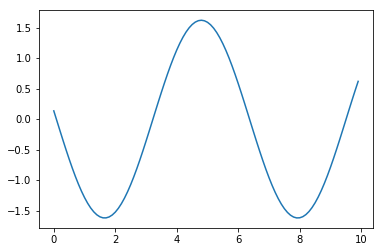

In [31]:
plt.plot(xs, to_save[0])
#plt.plot(xs, np.fft.fft(to_save[0]))
#plt.plot(xs, np.fft.irfft(np.fft.rfft(to_save[0],100)))

In [0]:

#plt.plot(np.fft.ifft(np.fft.fft(to_save[0][0:100:20]), 100))
# plt.plot(np.fft.rfft(to_save[0][0:100:5]))

In [0]:
# plt.plot(np.fft.irfft(np.fft.rfft(to_save[0][0:100:5])))

In [0]:
# from math import exp

# def rbf_kernel(x1, x2, variance = 1):
#     return exp(-1 * ((x1-x2) ** 2) / (2*variance))

# def gram_matrix(xs):
#     return [[rbf_kernel(x1,x2) for x2 in xs] for x1 in xs]

# xs = np.arange(0, 10, 0.1)
# mean = [0 for x in xs]
# gram = gram_matrix(xs)

# plt_vals = []
# to_save = []
# for i in range(0, 10000):
#     ys = np.random.multivariate_normal(mean, gram)
#     #to_save.extend([xs, ys])
#     to_save.append(ys)
#     #plt_vals.extend([xs, ys, "k"])
# #plt.plot(*plt_vals)
# #np.save('gaussian_process2.npy', to_save)
# #plt.show()


In [32]:
num_epochs = 20 #40
loss = nn.BCELoss()
num_test_samples = 4
rand_size = 1
latent_size = 5
batch_size = 16

# out = Variable(torch.randn(batch_size,latent_size)).cuda()
out = Variable(torch.randn(batch_size,2*latent_size)).cuda()
qz0_mean, qz0_logvar = out[:, :latent_size], out[:, latent_size:]
epsilon = torch.randn(qz0_mean.size()).cuda()
#epsilon between zero and 1
z_fixed = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean


#z_fixed = Variable(torch.randn(num_test_samples, latent_size)).cuda()

path = '../datasets_ideas/gaussian_process/cos_sin_normal_wave.npy'
data = np.array(to_save).astype(np.float32)#np.load(path).astype(np.float32)
data_size = 1000
data = data.reshape((data_size,-1,1))
# data = data.reshape((data_size,-1))
data_loader = data_iterable(data, batch_size)

batches_per_epoch = data_size//batch_size
data_gen = inf_generator(data_loader)
samp_ts = Variable(torch.from_numpy(np.arange(0, 10, 0.1)).cuda())
#samp_ts = Variable(torch.from_numpy(np.linspace(0,10,51)).cuda())
ts_size = 100

func = [ODEBlock(ODEfunc(latent_size), samp_ts)]
dec = [Decoder(latent_size,1)]
ode_index = 0

G = nn.Sequential(*func,*dec).cuda()
G.apply(init_weights)
# G.apply(normal_init)


D = CDiscriminator(ts_size).cuda()

g_lr = 1e-3
d_lr = 5e-5

g_min = 1e-5
d_min = 5e-6

noise_var = 0.3

d_optimizer = Adam(D.parameters(), lr=d_lr, betas=(0.5, 0.999))
g_optimizer = Adam(G.parameters(), lr=g_lr, betas=(0.5, 0.999))

f_nfe_meter = RunningAverageMeter()
b_nfe_meter = RunningAverageMeter()
save_path = 'checkpoint/'
for itr in range(num_epochs * batches_per_epoch):


    n_batch = itr % batches_per_epoch
    epoch = itr // batches_per_epoch
    real_batch = data_gen.__next__()

    if ((epoch+1) % 4 == 0) & (n_batch == 0):

        for param_group in g_optimizer.param_groups:
            g_lr = g_lr*0.7
            param_group['lr'] = max(g_lr,g_min)
            print('generator lr: ', max(g_lr,g_min))

        for param_group in d_optimizer.param_groups:
            d_lr = d_lr*0.7
            param_group['lr'] = max(d_lr, d_min)
            print('discriminator lr: ', max(d_lr,d_min))

    real_data = Variable(torch.tensor(real_batch).cuda())
    
    out = Variable(torch.randn(batch_size,2*latent_size)).cuda()
    qz0_mean, qz0_logvar = out[:, :latent_size], out[:, latent_size:]
    epsilon = torch.randn(qz0_mean.size()).cuda()
    #epsilon between zero and 1
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    
    #z0 = Variable(torch.randn(batch_size,latent_size)).cuda()
    fake_data = G(z0)
    #print(fake_data.size())
    # replay.update(fake_data)

    nfe_forward = G[ode_index].nfe
    G[ode_index].nfe = 0


    f_nfe_meter.update(nfe_forward)
    #print('forward: ', f_nfe_meter.avg)

    if torch.cuda.is_available(): real_data = real_data.cuda()
    # Generate fake data


    
    d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                            real_data + (noise_var*torch.randn(batch_size,ts_size, 1)).cuda(),
                                                            fake_data + (noise_var*torch.randn(batch_size,ts_size, 1)).cuda())
    # 2. Train Generator
    # Generate fake data
    
    
#     out = Variable(torch.randn(batch_size,2*latent_size)).cuda()
    out = Variable(torch.randn(batch_size,2*latent_size)).cuda()
    qz0_mean, qz0_logvar = out[:, :latent_size], out[:, latent_size:]
    epsilon = torch.randn(qz0_mean.size()).cuda()
    #epsilon between zero and 1
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    #z0 = Variable(torch.randn(batch_size,latent_size)).cuda()
    fake_data = G(z0)

    g_error = train_generator(g_optimizer, 
                              fake_data + (noise_var*torch.randn(batch_size,ts_size, 1)).cuda())

    G[ode_index].nfe = 0
    f_nfe_meter.update(nfe_forward)

    # end = time.time()

    # Display Progress

    if (n_batch) % 50 == 0:
        print(epoch)
        print(n_batch)
        print('forward: ', f_nfe_meter.avg)
        print('mean z0: ',z0[0].mean().cpu())
        print('d true avg decision: ',d_pred_real.mean().cpu().detach().numpy())
        print('d fake avg decision: ',d_pred_fake.mean().cpu().detach().numpy())
        print('discriminator error: ',d_error.cpu().detach().numpy())
        print('generator error: ',g_error.cpu().detach().numpy())
        #display.clear_output(True)


        fake_fixed = G(z_fixed).detach()

        fig, ax = plt.subplots(nrows=6, ncols=2)

        for i in range(2):
            for j in range(2):
                ax[i, j].plot(samp_ts.cpu().numpy(), fake_fixed[(i)*(2)+j].cpu().detach().numpy(), 'r')
                ax[i+2, j].plot(samp_ts.cpu().numpy(), real_data[(i)*(2)+j].cpu().detach().numpy(), 'g')
        for i in range(4,6):
            for j in range(2):
                ax[i, j].plot(samp_ts.cpu().numpy(), fake_data[np.random.choice(batch_size)].cpu().detach().numpy(), 'b')
                #col.plot(samp_ts.cpu().detach().numpy(), fake_data[(i+1)*(j+1)-1].cpu().numpy())
        #plt.figure()
        #plt.plot(samp_ts.cpu().detach().numpy(), fake_data[0].cpu().numpy())
        #plt.show()
        plt.savefig('fig'+str(epoch)+'_'+str(n_batch))
        plt.close()
  
        
        if n_batch == 0:
            torch.save({
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'g_optimizer_state_dict': g_optimizer.state_dict(),
            'd_optimizer_state_dict': d_optimizer.state_dict()
            },str(epoch)+'_'+str(n_batch)+'_saved_model_norm_.pth')
            
        # Display Images


        #print(test_y_.cpu().detach())
        #logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
        # Display status Logs
        #logger.display_status(
        #    epoch, num_epochs, n_batch, num_batches,
        #    d_error, g_error, d_pred_real, d_pred_fake
        #)
    # Model Checkpoints
    #logger.save_models(generator, discriminator, epoch)


0
0
forward:  32.0
mean z0:  tensor(0.2782)
d true avg decision:  0.5973225
d fake avg decision:  0.58780825
discriminator error:  1.4103606
generator error:  -0.5709713
0
50
forward:  32.237822053793295
mean z0:  tensor(0.6927)
d true avg decision:  0.6479572
d fake avg decision:  0.5710981
discriminator error:  1.3724856
generator error:  -0.58520514
1
0
forward:  32.69732994848573
mean z0:  tensor(1.3370)
d true avg decision:  0.56553197
d fake avg decision:  0.54446256
discriminator error:  1.4776039
generator error:  -0.56746614
1
50
forward:  33.709930044620194
mean z0:  tensor(0.7380)
d true avg decision:  0.49784803
d fake avg decision:  0.5149876
discriminator error:  1.6542741
generator error:  -0.45239317
2
0
forward:  33.970956957786065
mean z0:  tensor(0.8691)
d true avg decision:  0.5515098
d fake avg decision:  0.49928164
discriminator error:  1.5002923
generator error:  -0.5361647
2
50
forward:  34.90245955602094
mean z0:  tensor(-1.1309)
d true avg decision:  0.6105021

In [0]:
!rm *.png